In [1]:
import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from deep_macrofin import PDEModel
from deep_macrofin import ActivationType, Comparator, Constraint, SamplingMethod, LossReductionMethod, LayerType, System, plot_loss_df, set_seeds

In [2]:
latex_var_mapping = {
    r"\sigma_t^q": "sigq",
    r"\sigma_t^\theta": "sigtheta",
    r"\sigma_t^\eta": "sige",
    r"\mu_t^\eta": "mue",
    r"\mu_t^q": "muq",
    r"\mu_t^\theta": "mutheta",


    r"\rho": "rho",
    r"\underline{a}": "ah",
    r"\underline{\delta}": "deltah",
    r"\delta": "deltae",
    r"\sigma": "sig",
    r"\kappa": "kappa",

    r"\eta": "e",

    r"\theta": "theta",
    r"\psi": "psi",
    r"\iota": "iota",
    r"\Phi": "phi",

}

## BCs

$$q(0) * r + \frac{q(0)^2 - 1}{2*\kappa} - \underline{a}=0 \Rightarrow q(0)=-\kappa*r + \sqrt{\kappa^2*r^2+1+2*\underline{a}*\kappa}$$

$$q(1) * \rho + \frac{q(1)^2 - 1}{2*\kappa} - a=0 \Rightarrow q(1)=-\kappa*\rho + \sqrt{\kappa^2*\rho^2+1+2*a*\kappa}$$

$$\psi(0)=0, \psi(1)=1$$

## Region 1
$\psi < 1$

Equations to solve:

$$
\begin{cases}
(r*(1-\eta) + \rho * \eta) * q = \psi * a + (1-\psi) * \underline{a} - \iota\\
(\sigma + \sigma_t^q) ^2 * \frac{q * (\psi - \eta)}{\eta * (1-\eta)} = (a - \underline{a}) + (\underline{\delta} - \delta) * q
\end{cases}
$$

## Region 2
$\psi = 1$

The only equation to solve in this region is

$$(r*(1-\eta) + \rho * \eta) * q = a - \iota$$

=====================Summary of Model BruSan14_log_utility======================
Config: {
 "batch_size": 1000,
 "num_epochs": 200,
 "lr": 0.001,
 "loss_log_interval": 1,
 "optimizer_type": "AdamW",
 "sampling_method": "FixedGrid",
 "loss_balancing": false,
 "bernoulli_prob": 0.9999,
 "loss_balancing_temp": 0.1,
 "loss_balancing_alpha": 0.999,
 "soft_adapt_interval": -1,
 "loss_soft_attention": false
}
Latex Variable Mapping:
{
 "\\sigma_t^q": "sigq",
 "\\sigma_t^\\theta": "sigtheta",
 "\\sigma_t^\\eta": "sige",
 "\\mu_t^\\eta": "mue",
 "\\mu_t^q": "muq",
 "\\mu_t^\\theta": "mutheta",
 "\\rho": "rho",
 "\\underline{a}": "ah",
 "\\underline{\\delta}": "deltah",
 "\\delta": "deltae",
 "\\sigma": "sig",
 "\\kappa": "kappa",
 "\\eta": "e",
 "\\theta": "theta",
 "\\psi": "psi",
 "\\iota": "iota",
 "\\Phi": "phi"
}
User Defined Parameters:
{
 "sig": 0.1,
 "deltae": 0.05,
 "deltah": 0.05,
 "rho": 0.06,
 "r": 0.05,
 "a": 0.11,
 "ah": 0.07,
 "kappa": 2
}

================================State V

c:\Users\yunta\AppData\Local\Programs\Python\Python311\Lib\site-packages\deep_macrofin\models\kan\KAN.py:329: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))


====================================Training====================================


Total loss: 0.0116: 100%|██████████| 200/200 [00:18<00:00, 10.58it/s]
C:\Users\yunta\AppData\Local\Temp\ipykernel_26056\3670443389.py:107: RuntimeWarning: invalid value encountered in multiply
  er_nn = er_region1 * index_unconstrain + er_region2 * index_constrain


training finished, total time :: 18.91228175163269
Best model saved to ./models/BruSan14_log_utility_system_kan/model_best.pt if valid
Model saved to ./models/BruSan14_log_utility_system_kan/model.pt
Model loaded
===================================Evaluating===================================
loss :: endogvar_q_cond_q_min: 0.0000,
endogvar_q_cond_q_max: 0.0000,
endogvar_psi_cond_psi_min: 0.0000,
endogvar_psi_cond_psi_max: 0.0000,
system_crisis_region: 0.0084,
system_normal_region: 0.0019,
total_loss: 0.0116


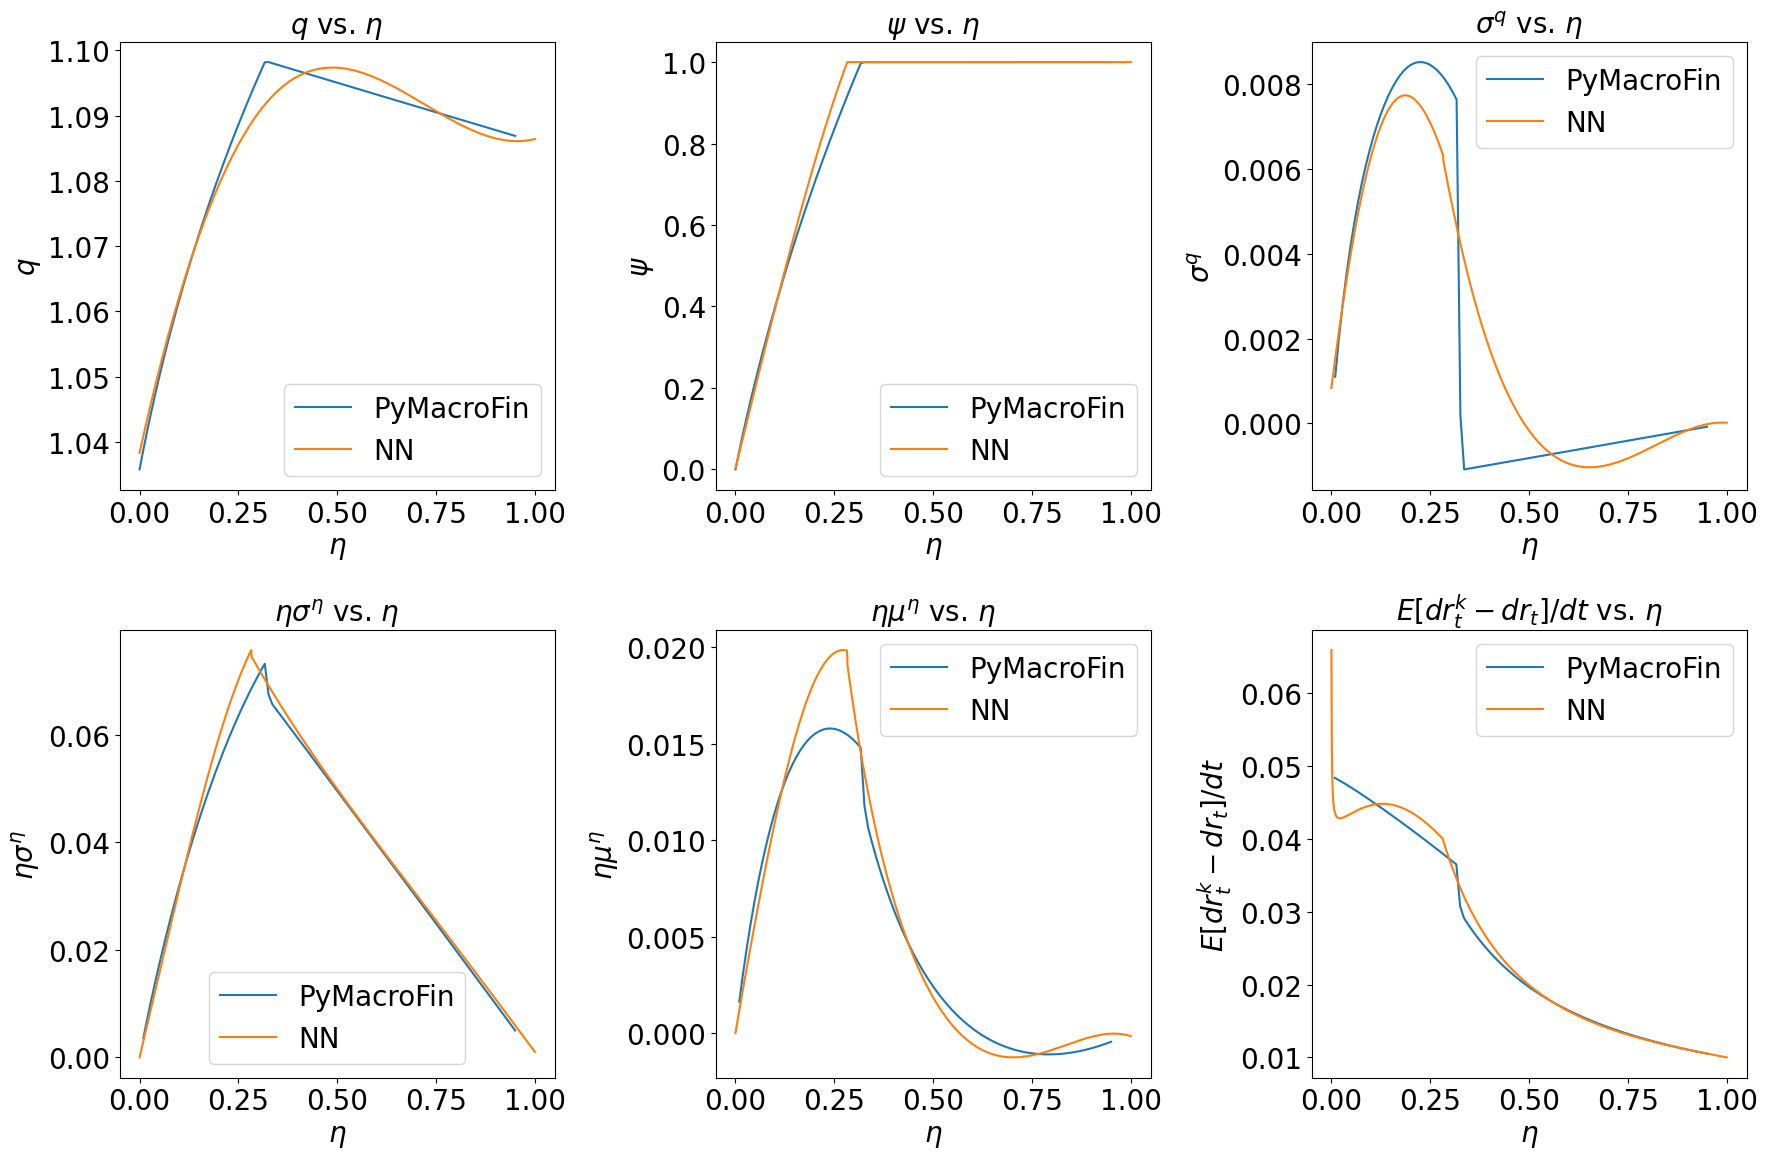

In [3]:
set_seeds(0)
pde_model = PDEModel("BruSan14_log_utility", {"sampling_method": SamplingMethod.FixedGrid, "batch_size": 1000,
    "num_epochs": 200, "loss_log_interval": 1}, latex_var_mapping=latex_var_mapping)
pde_model.set_state(["e"], {"e": [0.01, 0.99]})
pde_model.add_endogs(["q", "psi"], configs={
    "q": {
        "hidden_units": [1, 1],
        "layer_type": LayerType.KAN,
        "activation_type": ActivationType.SiLU,
    },
    "psi": {
        "hidden_units": [1, 1],
        "layer_type": LayerType.KAN,
        "activation_type": ActivationType.SiLU,
    }
})
pde_model.add_params({
    "sig": .1,
    "deltae": .05,
    "deltah": .05,
    "rho": .06,
    "r": .05,
    "a": .11,
    "ah": .07,
    "kappa": 2,
})
pde_model.add_endog_condition("q", 
                              "q(SV)", 
                              {"SV": torch.zeros((1, 1))},
                              Comparator.EQ,
                              "-kappa*r + (kappa**2*r**2 + 1 + 2*ah*kappa)**0.5", {"r": 0.05, "ah": .07, "kappa": 2},
                              label="q_min", weight=100)
pde_model.add_endog_condition("q", 
                              "q(SV)", 
                              {"SV": torch.ones((1, 1))},
                              Comparator.EQ,
                              "-kappa*rho + (kappa**2*rho**2 + 1 + 2*a*kappa)**0.5", {"rho": 0.06, "a": .11, "kappa": 2},
                              label="q_max", weight=100)
pde_model.add_endog_condition("psi", 
                              "psi(SV)", 
                              {"SV": torch.zeros((1, 1))},
                              Comparator.EQ,
                              "0", {},
                              label="psi_min", weight=100)
pde_model.add_endog_condition("psi", 
                              "psi(SV)", 
                              {"SV": torch.ones((1, 1))},
                              Comparator.EQ,
                              "1", {},
                              label="psi_max", weight=100)

sys1 = System([Constraint("psi", Comparator.LT, "1", label="crisis_constraint")], label="crisis_region", latex_var_mapping=latex_var_mapping)
sys1.add_equation(r"$\iota = \frac{q^2-1}{ 2 * \kappa}$")
sys1.add_equation(r"$\sigma_t^q = \frac{\sigma}{1 - \frac{1}{q} * \frac{\partial q}{\partial \eta} * (\psi - \eta)} - \sigma$")
sys1.add_equation(r"$\sigma_t^\eta = \frac{\psi - \eta}{\eta} * (\sigma + \sigma_t^q)$")
sys1.add_equation(r"$\mu_t^\eta = (\sigma_t^\eta)^2 + \frac{a - \iota}{q} + (1-\psi) * (\underline{\delta} - \delta) - \rho$")

sys1.add_endog_equation(r"$(r*(1-\eta) + \rho * \eta) * q = \psi * a + (1-\psi) * \underline{a} - \iota$", loss_reduction=LossReductionMethod.SSE)
sys1.add_endog_equation(r"$(\sigma + \sigma_t^q) ^2 * \frac{q * (\psi - \eta)}{\eta * (1-\eta)} = (a - \underline{a}) + (\underline{\delta} - \delta) * q$", loss_reduction=LossReductionMethod.SSE, weight=2)

sys2 = System([Constraint("psi", Comparator.GEQ, "1", label="crisis_constraint")], label="normal_region", latex_var_mapping=latex_var_mapping)
sys2.add_equation(r"$\iota = \frac{q^2-1}{ 2 * \kappa}$")
sys2.add_equation(r"$\sigma_t^q = \frac{\sigma}{1 - \frac{1}{q} * \frac{\partial q}{\partial \eta} * (1 - \eta)} - \sigma$")
sys2.add_equation(r"$\sigma_t^\eta = \frac{1 - \eta}{\eta} * (\sigma + \sigma_t^q)$")
sys2.add_equation(r"$\mu_t^\eta = (\sigma_t^\eta)^2 + \frac{a - \iota}{q} - \rho$")

sys2.add_endog_equation(r"$(r*(1-\eta) + \rho * \eta) * q = a - \iota$", loss_reduction=LossReductionMethod.SSE)

pde_model.add_system(sys1)
pde_model.add_system(sys2)

print(pde_model)
if not os.path.exists("./models/BruSan14_log_utility_system_kan/model.pt"):
    pde_model.train_model("./models/BruSan14_log_utility_system_kan", "model.pt", True)
    pde_model.load_model(torch.load("./models/BruSan14_log_utility_system_kan/model_best.pt"))
    pde_model.eval_model(True)
else:
    pde_model.load_model(torch.load("./models/BruSan14_log_utility_system_kan/model_best.pt"))
    pde_model.eval_model(True)

N = 1000
SV = torch.linspace(0, 1, N, device=pde_model.device).reshape(-1, 1)
x_plot = SV.detach().cpu().numpy().reshape(-1)
for i, sv_name in enumerate(pde_model.state_variables):
    pde_model.variable_val_dict[sv_name] = SV[:, i:i+1]
pde_model.update_variables(SV)
q_nn = pde_model.variable_val_dict["q"].detach().cpu().numpy().reshape(-1)
psi_region1 = pde_model.variable_val_dict["psi"].detach().cpu().numpy().reshape(-1)
sigq_region1 = pde_model.systems["system_crisis_region"].variable_val_dict["sigq"].detach().cpu().numpy().reshape(-1)
esige_region1 = (SV * pde_model.systems["system_crisis_region"].variable_val_dict["sige"]).detach().cpu().numpy().reshape(-1)
emue_region1 = (SV * pde_model.systems["system_crisis_region"].variable_val_dict["mue"]).detach().cpu().numpy().reshape(-1)
er_region1 = (pde_model.variable_val_dict["psi"] / SV * (pde_model.variable_val_dict["sig"] + pde_model.systems["system_crisis_region"].variable_val_dict["sigq"])**2).detach().cpu().numpy().reshape(-1)

psi_region2 = np.ones_like(x_plot)
sigq_region2 = pde_model.systems["system_normal_region"].variable_val_dict["sigq"].detach().cpu().numpy().reshape(-1)
esige_region2 = (SV * pde_model.systems["system_normal_region"].variable_val_dict["sige"]).detach().cpu().numpy().reshape(-1)
emue_region2 = (SV * pde_model.systems["system_normal_region"].variable_val_dict["mue"]).detach().cpu().numpy().reshape(-1)
er_region2 = (1 / SV * (pde_model.variable_val_dict["sig"] + pde_model.systems["system_normal_region"].variable_val_dict["sigq"])**2).detach().cpu().numpy().reshape(-1)

index_unconstrain = (psi_region1 < 1)
index_constrain = (psi_region1 >= 1)

psi_nn = psi_region1 * index_unconstrain + 1 * index_constrain
sigq_nn = sigq_region1 * index_unconstrain + sigq_region2 * index_constrain
esige_nn = esige_region1 * index_unconstrain + esige_region2 * index_constrain
emue_nn = emue_region1 * index_unconstrain + emue_region2 * index_constrain
er_nn = er_region1 * index_unconstrain + er_region2 * index_constrain

xlabel = "$\eta$"
plot_args = [
    {"y": q_nn, "ylabel": r"$q$", "title": r"$q$ vs. $\eta$"},
    {"y": psi_nn, "ylabel": r"$\psi$", "title": r"$\psi$ vs. $\eta$"},
    {"y": sigq_nn, "ylabel": r"$\sigma^q$", "title": r"$\sigma^q$ vs. $\eta$"},
    {"y": esige_nn, "ylabel": r"$\eta\sigma^{\eta}$", "title": r"$\eta\sigma^{\eta}$ vs. $\eta$"},
    {"y": emue_nn, "ylabel": r"$\eta\mu^{\eta}$", "title": r"$\eta\mu^{\eta}$ vs. $\eta$"},
    {"y": er_nn, "ylabel": r"$E[dr_t^k-dr_t]/dt$", "title": r"$E[dr_t^k-dr_t]/dt$ vs. $\eta$"},
]

df = pd.read_csv("models/BruSan14_log_utility_solution-raw.csv")
plot_args_base = [
    {"y": df["q"], "ylabel": r"$q$", "title": r"$q$ vs. $\eta$"},
    {"y": df["psi"], "ylabel": r"$\psi$", "title": r"$\psi$ vs. $\eta$"},
    {"y": df["sigq"], "ylabel": r"$\sigma^q$", "title": r"$\sigma^q$ vs. $\eta$"},
    {"y": df["sigee"], "ylabel": r"$\eta\sigma^{\eta}$", "title": r"$\eta\sigma^{\eta}$ vs. $\eta$"},
    {"y": df["muee"], "ylabel": r"$\eta\mu^{\eta}$", "title": r"$\eta\mu^{\eta}$ vs. $\eta$"},
    {"y": df["er"], "ylabel": r"$E[dr_t^k-dr_t]/dt$", "title": r"$E[dr_t^k-dr_t]/dt$ vs. $\eta$"},
]
x_plot_base = df["e"]

plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(2, 3, figsize=(18, 12))
for i, plot_arg in enumerate(plot_args):
    row = i // 3
    col = i % 3
    curr_ax = ax[row, col]
    curr_ax.plot(x_plot_base, plot_args_base[i]["y"], label="PyMacroFin")
    curr_ax.plot(x_plot, plot_arg["y"], label="NN")
    curr_ax.set_xlabel(xlabel)
    curr_ax.set_ylabel(plot_arg["ylabel"])
    curr_ax.set_title(plot_arg["title"], fontsize=20)
    curr_ax.legend()
plt.tight_layout()
plt.show()